In [1]:
import torch
from random import shuffle
from torch.nn import Sigmoid,BCELoss, MSELoss, Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Upsample
from torch.optim import Adam, SGD
from torchvision import datasets, transforms
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy.ndimage as ndimage
import random
import os

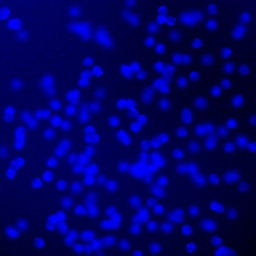

In [2]:
Image.open("data/train/cells/017cell.png")

In [3]:
input = 1
input

1

(256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


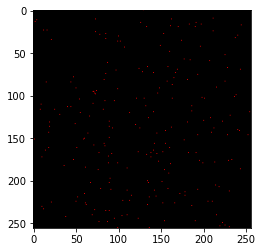

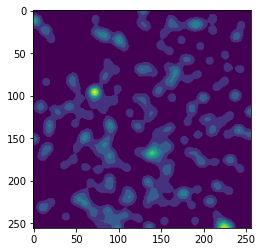

In [4]:
img = np.array(Image.open("data/train/dots/017dots.png"))
img2 = 255 * (img[:,:,0] > 0)
img2 = ndimage.gaussian_filter(img2, sigma=(5, 5), order=0)
print(img2.shape)
print(img2)
Image.fromarray(img2.astype(np.uint8))
plt.imshow(img)
plt.show()
plt.imshow(img2)
plt.show()

# Fonctions de loss

In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn
# Recommend
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss2d, self).__init__()
        self.nll_loss = nn.NLLLoss2d(weight, size_average)

    def forward(self, inputs, targets):
        return self.nll_loss(F.log_softmax(inputs), targets)
    
class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

# Chargement des images

In [6]:
class ImageFolderSegmentation():
    def __init__(self, images_folder=None, masks_folder=None, img_transforms=None, mask_transforms=None, batch_size=1):
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        self.images_paths = []
        self.masks_paths = []
        self.batch_size = batch_size
        self.cursor = 0
        self.nb_objects = 0
        
        for filename in glob.glob(images_folder+"/*.png"):
            self.images_paths.append(filename)
            self.nb_objects+=1
            
        for filename in glob.glob(masks_folder+"/*.png"):
            self.masks_paths.append(filename)
        self.images_paths.sort()
        self.masks_paths.sort()
    def __iter__(self):
        return self

    def __next__(self):
        y = []
        x = []
        for data_id in range(self.cursor, self.cursor+self.batch_size):
            img = Image.open(self.images_paths[data_id])
            mask = Image.open(self.masks_paths[data_id])
            
            seed = np.random.randint(2147483647) # make a seed with numpy generator 
            random.seed(seed) # apply this seed to img tranfsorms
            torch.manual_seed(seed) # needed for torchvision 0.7

            if self.img_transforms is not None:
                img = np.array(img).astype(float)
                img*= (255.0/img.max())
                img = img.astype(np.uint8)
                img = Image.fromarray(img)
                img = self.img_transforms(img)
                img*= (1.0/img.max())
                img = img.float()
                
            
            torch.manual_seed(seed) # needed for torchvision 0.7
            if self.mask_transforms is not None:
                mask = 255.0 * (np.array(mask)[:,:,0] > 0)
                mask = ndimage.gaussian_filter(mask, sigma=(5, 5), order=0)
                mask*= (255.0/mask.max())
                mask = Image.fromarray(mask.astype(np.uint8))
                mask = self.mask_transforms(mask)
                mask*= (1.0/mask.max())
                mask = mask.float()
                

            self.cursor+=1
            if self.cursor == self.nb_objects:
                self.cursor = 0
                raise StopIteration
            x.append(img)
            y.append(mask)
        
        x_tensor = torch.Tensor(len(x), x[0].shape[0], x[0].shape[1])
        torch.cat(x, out=x_tensor)
        x_tensor= torch.reshape(x_tensor, (x_tensor.shape[0], 1, x_tensor.shape[1], x_tensor.shape[2]))
        
        y_tensor = torch.Tensor(len(y), y[0].shape[0], y[0].shape[1])
        torch.cat(y, out=y_tensor)
        y_tensor = torch.reshape(y_tensor, (y_tensor.shape[0], 1, y_tensor.shape[1], y_tensor.shape[2]))
        
        #y_tensor = torch.argmax(y_tensor, dim=1)
        return x_tensor, y_tensor
        

In [7]:
img_transforms = transforms.Compose([
                                     transforms.Resize((100,100), interpolation=Image.NEAREST),
                                     transforms.ToTensor(),transforms.Grayscale(num_output_channels=1)])
img = Image.open("data/train/cells/010cell.png")
img = np.array(img).astype(float)
img*= (255.0/img.max())
img = img.astype(np.uint8)
print(img.max())
img = Image.fromarray(img)
img = img_transforms(img)
img*= (1.0/img.max())
img = img.float()
print(img.max())

255
tensor(1.)


torch.Size([10, 1, 100, 100])
torch.Size([10, 1, 100, 100])
tensor(1.)


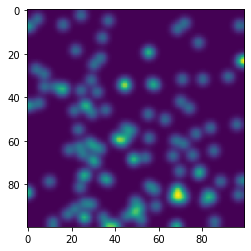

tensor(1.)


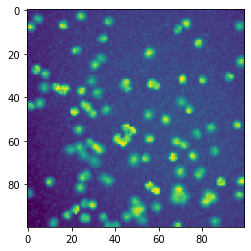

In [8]:
img_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.Resize((100,100), interpolation=Image.NEAREST),
                                     transforms.ToTensor()])

generator = ImageFolderSegmentation(images_folder="data/train/cells", masks_folder="data/train/dots", img_transforms=img_transforms, mask_transforms=img_transforms, batch_size=10)
x,y = next(generator)
print(x.shape)
print(y.shape)
mask = np.reshape(y[0], (100,100))
print(mask.max())
plt.imshow(mask)
plt.show()
mask = np.reshape(x[0], (100,100))
print(mask.max())
plt.imshow(mask)
plt.show()

# Implémentation du modèle

In [9]:
# FCRN-B
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        
        self.first_layer = Sequential(
            # Defining a 2D convolution layer
            # 1st layer
            Conv2d(1, 32, kernel_size=(3,3), stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(), # inplace true --> save memory
            MaxPool2d(kernel_size=4, stride=2) # 100 --> 50
        )
        self.second_layer = Sequential(
           Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=1),
            BatchNorm2d(64),
            ReLU()
        )

        
        self.third_layer = Sequential(
           Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=1),
            BatchNorm2d(128),
            ReLU(),
            MaxPool2d(kernel_size=4, stride=2) # 50 --> 25
        )
        self.fourth_layer = Sequential(
            Conv2d(128, 256, kernel_size=(5,5), stride=1, padding=2),
            BatchNorm2d(256),
            ReLU()
        )
        self.fifth_layer = Sequential(
            Conv2d(256, 256, kernel_size=(3,3), stride=1, padding=1)
        )
        
        self.sixth_layer = Sequential(
            Upsample(size=(50,50)),
            Conv2d(256, 256, kernel_size=(5,5), stride=1, padding=2),
            ReLU(),
            BatchNorm2d(256)
        )
        
        self.output_layer = Sequential(
            Upsample(size=(100,100)),
            Conv2d(256, 1, kernel_size=(5,5), stride=1, padding=2),
            BatchNorm2d(1),
            #Linear(inplace=True),
            ReLU()
            #ReLU()
        )


        self.fcrn_b = Sequential(
            # Defining a 2D convolution layer
            # 1st layer
            Conv2d(1, 32, kernel_size=(3,3), stride=1, padding=1),
            ReLU(inplace=True), # inplace true --> save memory
            MaxPool2d(kernel_size=4, stride=2), # 100 --> 50
            # 2nd layer
            Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=1),
            ReLU(inplace=True),
            # 3rd layer
            Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=4, stride=2), # 50 --> 25
            # 4rth layer
            Conv2d(128, 256, kernel_size=(5,5), stride=1, padding=2),
            ReLU(inplace=True), 
            # 5th layer FC
            Conv2d(256, 256, kernel_size=(3,3), stride=1, padding=1),
            # 6th layer
            Upsample(size=(50,50)),
            ReLU(inplace=True),
            Conv2d(256, 256, kernel_size=(5,5), stride=1, padding=2),
            
            #Output
            Upsample(size=(100,100))
            
        )


    # Defining the forward pass    
    def forward(self, x):
        x = self.first_layer(x)
        x = self.second_layer(x)
        x = self.third_layer(x)
        x = self.fourth_layer(x)
        x = self.fifth_layer(x)
        x = self.sixth_layer(x)
        x = self.output_layer(x)
        return x
    

def fit_generator(model,
        optimizer,
        criterion,
        train_generator=None,
        epochs=5,
        verbose=1,
        validation_split=0.0,
        validation_generator=None
    ):
    
    if validation_generator is None:
        train_generator, validation_generator = torch.utils.data.random_split(dataset=train_generator, lengths=[int(len(testloader.dataset)*(1-validation_split)), int(len(testloader.dataset)*(validation_split))])
    epochs_list = []
    val_losses = []
    train_losses = []
    for epoch in range(0, epochs):
        # Training
        model.train()
        running_train_loss = 0
        nb_batches_train = 0
        for x, y_label in train_generator:
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(x)
            #loss = criterion(outputs, torch.argmax(y_label, dim=1))
            loss = criterion(outputs, y_label)
            loss.backward()
            optimizer.step()
            
            #print(round(float(loss), 4), end='\r')
            running_train_loss+=loss
            nb_batches_train+=1
       # plt.imshow(np.reshape(outputs.detach().numpy()[0], (100,100)))
        #plt.show()
        #plt.imshow(np.reshape(y_label.detach().numpy()[0], (100,100)))
        #plt.show()
        #plt.imshow(np.reshape(x.detach().numpy()[0], (100,100)))
        #plt.show()
        # Validation
        model.eval()
        running_val_loss = 0
        nb_batches_val = 0
        for x, y_label in validation_generator:
            # forward + backward + optimize
            outputs = model(x)
            #running_val_loss += criterion(outputs, torch.argmax(y_label, dim=1))
            running_val_loss += criterion(outputs, y_label)
            nb_batches_val+=1
        #sys.stdout.flush()
        mean_train_loss = round(float(running_train_loss/nb_batches_train),4)
        mean_val_loss = round(float(running_val_loss/nb_batches_val),4)
        
        epochs_list.append(epoch)
        val_losses.append(mean_val_loss)
        train_losses.append(mean_train_loss)
        from IPython.display import clear_output
        clear_output()
        print("Epoch n°",epoch+1,"- train_loss:",mean_train_loss , "- val_loss:", mean_val_loss)
        plt.plot(epochs_list, val_losses, c='orange')
        plt.plot(epochs_list, train_losses, c='blue')
        plt.show()


    return

# Entrainement

Epoch n° 17 - train_loss: 0.0175 - val_loss: 0.0165


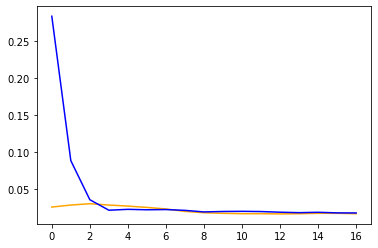

In [ ]:
from math import sqrt
model = Net()
# defining the optimizer
#optimizer = SGD(model.parameters(), lr=0.007, momentum=0.9, nesterov=True, weight_decay=1e-5)
optimizer = Adam(model.parameters(), lr=0.014, weight_decay=1e-5)
# defining the loss function
def my_loss(output, target):
    #print(output.max())
    #loss = torch.mean((output - target)**2)*30
    #plt.imshow(np.reshape((output- target)[0].detach().numpy(), (100,100)))
    #plt.show()
    loss = torch.mean(((output- target))**2)
    return loss
criterion = MSELoss()

    
#print(model)


#Applying Transformation
img_transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.Resize((100,100), interpolation=Image.NEAREST),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomRotation((-180,180)),
                                    transforms.ToTensor()])

train_generator = ImageFolderSegmentation(images_folder="data/train/cells", masks_folder="data/train/dots", img_transforms=img_transforms, mask_transforms=img_transforms, batch_size=4)
test_generator = ImageFolderSegmentation(images_folder="data/test/cells", masks_folder="data/test/dots", img_transforms=img_transforms, mask_transforms=img_transforms, batch_size=4)


fit_generator(model,
        optimizer,
        criterion,
        train_generator=train_generator,
        epochs=100,
        verbose=1,
        validation_generator=test_generator)

# Exemple de prediction sur l'ensemble de test

In [ ]:
def my_loss(output, target):
    loss = torch.mean((output - target)**2)*100
    return loss

#train_generator = ImageFolderSegmentation(images_folder="data/train/cells", masks_folder="data/train/dots", img_transforms=img_transforms, mask_transforms=img_transforms, batch_size=4)
#test_generator = ImageFolderSegmentation(images_folder="data/test/cells", masks_folder="data/test/dots", img_transforms=img_transforms, mask_transforms=img_transforms, batch_size=4)
x, y = next(test_generator)
criterion =  MSELoss()

y_pred =model.forward(x)
print(float(my_loss(y_pred, y)))
print(float(criterion(y_pred, y)))
print(y_pred.max())
print(y.max())

y_pred = np.array(model.forward(x).detach().numpy())
plt.imshow(np.reshape(x[1], (100,100)))
plt.show()
plt.imshow(np.reshape(y[1], (100,100)))
plt.show()
plt.imshow(np.reshape(y_pred[0], (100,100)))
plt.show()